# Malaria Detection Using Deep Convolutional Neural Networks

![](https://www.mayoclinic.org/-/media/kcms/gbs/patient-consumer/images/2013/08/26/10/13/ds00475_im00175_mcdc7_malaria_transmitthu_jpg.jpg)

Convolutional Neural Networks and Computer Vision has disrupted the healthcare industry in the recent years. These CNNs can detect anomalies in the scans of vital organs such as heart, liver, lungs and brain. 
They can also detect Malaria, which is a life threatening disease caused by parasites, from red blood cells. It is transmitted to people through the bites of infected female Anopheles mosquitoes. 

In the [Improving Malaria Parasite Detection from Red Blood Cell using Deep Convolutional Neural Networks](https://arxiv.org/ftp/arxiv/papers/1907/1907.10418.pdf) paper, researchers use a transfer learning technique using a pre-trained `VGG16` model. The experiments were conducted on data obtained from National Institute of Health named NIH Malaria Dataset.Their model achieves an accuracy of 97.77%.

The motivation of this project is to display my knowledge on image classification and transfer learning while
trying to beat the 97.77% accuracy. The dataset for this preoject is downloaded from Kaggle. The transfer learning models I will experiment with are:

* InceptionV3
* ResNet101V2
* VGG 19
* VGG16

In [ ]:
# Importing the Dependancies
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, applications
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import mixed_precision
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import pandas as pd
import numpy as np
import zipfile
import os
import pathlib

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Checking GPU

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-669a86d3-5a12-6760-bc7b-68861e6cf552)


## Downloading the Dataset From Kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

In [ ]:
zip_ref = zipfile.ZipFile('cell-images-for-detecting-malaria.zip', 'r')
zip_ref.extractall()
zip_ref.close()

## Exploring the Dataset



In [ ]:
!ls cell_images

cell_images  Parasitized  Uninfected


In [ ]:
# Walking through the cell images directory and list number of files

for dirpath, dirnames, filenames in os.walk('cell_images'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'cell_images'.
There are 0 directories and 13780 images in 'cell_images/Parasitized'.
There are 2 directories and 0 images in 'cell_images/cell_images'.
There are 0 directories and 13780 images in 'cell_images/cell_images/Parasitized'.
There are 0 directories and 13780 images in 'cell_images/cell_images/Uninfected'.
There are 0 directories and 13780 images in 'cell_images/Uninfected'.


There is two classes in the directory. Parasitized and uninfected images, which means this is a binary classification problem. Both classes contain 13780 images.

In [ ]:
# Getting the class names as a list

data_dir = pathlib.Path("cell_images/cell_images")
class_names = list(sorted([item.name for item in data_dir.glob('*')]))
class_names

['Parasitized', 'Uninfected']

In [ ]:
# Checking the min max values of a tensor
random_image = random.sample(os.listdir('cell_images/cell_images/Uninfected'), 1)
image_path = data_dir.name + '/Uninfected/' + random_image[0]
image = mpimg.imread(image_path)
print(image[10,40:50,:])
print(f'\nmininum (pixel) value: {tf.reduce_min(image)}',
f'\nmaximum (pixel) value: {tf.reduce_max(image)}', 
f'\nimage datatye: {image.dtype}',
)

[[0.84705883 0.6627451  0.6392157 ]
 [0.84705883 0.6627451  0.6392157 ]
 [0.84313726 0.65882355 0.63529414]
 [0.84705883 0.654902   0.63529414]
 [0.84705883 0.654902   0.63529414]
 [0.8509804  0.65882355 0.6392157 ]
 [0.84705883 0.654902   0.63529414]
 [0.84313726 0.6509804  0.6313726 ]
 [0.84313726 0.6509804  0.6313726 ]
 [0.84313726 0.6509804  0.6313726 ]]

mininum (pixel) value: 0.0 
maximum (pixel) value: 0.8784313797950745 
image datatye: float32


Seems like images are already scaled in between 0 and 1

### Visualizing random samples from both classes

In [ ]:
def view_random_image(target_dir, target_class):
  plt.figure(figsize=(10,10))
  target_folder = target_dir + '/' + target_class
  random_images = random.sample(os.listdir(target_folder), 9)
  for i, image in enumerate(random_images):
    ax = plt.subplot(3, 3, i + 1)
    img = mpimg.imread(target_folder + "/" + image)
    plt.imshow(img)
    plt.title(f'class: {target_class} ' + '\n' f'image shape: {img.shape}')
    plt.axis("off");

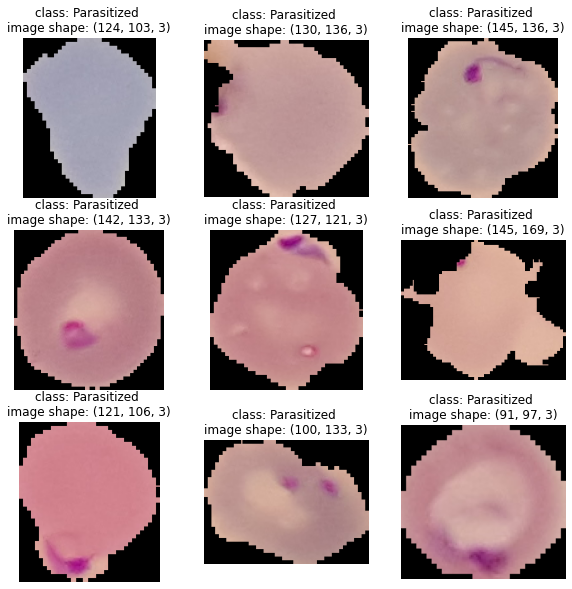

In [ ]:
view_random_image(data_dir.name, 'Parasitized')

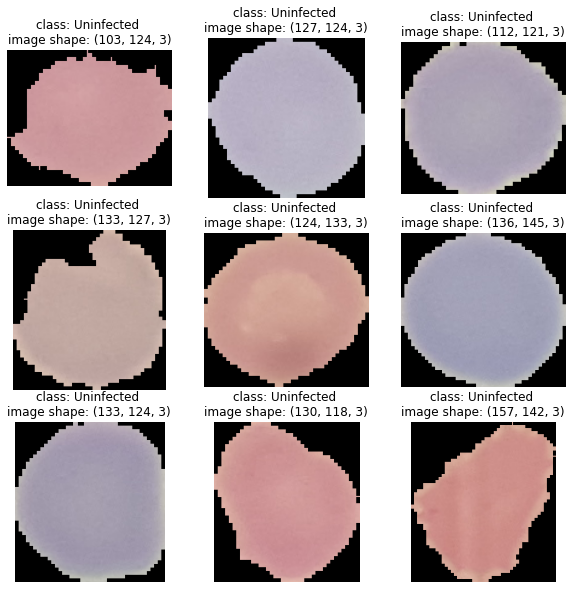

In [ ]:
view_random_image(data_dir.name, 'Uninfected')

We can see that parasitized cells have one or multiple spots in different color. The shape of some cells in both classes are also distorted. It also important to note that images are also in different sizes for preprocessing purposes.

## Preprocessing the Data

* The data is already scaled for us. It is in the `float32`, which is ideal. However, I will use [mixed precision](https://www.tensorflow.org/guide/mixed_precision) training to increase the training speed of the models. 

* The images are in different sizes. I will use `ImageDataGenerator()` to resize every image to a common size of (128, 128, 3) - 3 being the different color channels. I will also create training, validation and test sets that contain images from both classes (infected and uninfected).

* I will turn the training dataset into batches, which it is more memory efficient. I will use the batch size of 32, which is commonly used number in the machine learning community.

* I will prefetch the training dataset which improves data loading speed but costs memory.

In [ ]:
# Creating training and test sets

train_data = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                                 label_mode = 'binary',
                                                                 validation_split=0.2,
                                                                 seed=23,
                                                                 subset="training",
                                                                 image_size=(128,128),
                                                                 batch_size=32,
                                                                 shuffle=True)
                                                            
test_data = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                                label_mode = 'binary',
                                                                validation_split=0.2,
                                                                seed=23,
                                                                subset="validation",
                                                                image_size=(128,128),
                                                                batch_size=32,
                                                                shuffle=True)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


Checking both datasets to see if the labels are in the right form (1 or 0), the images are shuffled and both datasets include images from both classes (infected and uninfected)

In [ ]:
for image,label in train_data.take(1):
  print(tf.squeeze(label))

tf.Tensor(
[0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1.
 1. 0. 0. 1. 0. 1. 0. 0.], shape=(32,), dtype=float32)


In [ ]:
for image,label in test_data.take(1):
  print(tf.squeeze(label))

tf.Tensor(
[0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1.
 1. 0. 0. 1. 1. 1. 1. 0.], shape=(32,), dtype=float32)


In [ ]:
# Prefetcing the datasets

train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 1)), types: (tf.float32, tf.float32)>

In [ ]:
# Setting up mixed precision training

mixed_precision.set_global_policy(policy="mixed_float16")
mixed_precision.global_policy()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


<Policy "mixed_float16">

## Creating Modelling Callbacks

In [ ]:
# Creating ModelCheckpoint callback to save a model's progress during training
checkpoint_path = 'model_checkpoints/cp.chkpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                      monitor='val_acc',
                                                      save_best_only=True,
                                                      save_weights_only=True, 
                                                      verbose=0)

In [ ]:
# Creating an EarlyStopping callback which stops the training when there is no improvement in the specified parameter
early_stopping = EarlyStopping(monitor='val_loss',patience=2)

## Building The Models


In [ ]:
# Creating a the function to compile the model, fit it to the dataset and save it

def create_model(train_data, test_data, model, epochs, lr=0.001):

  model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                metrics=['accuracy'])
  
  hist = model.fit(train_data,
                epochs=epochs,
                steps_per_epoch=len(train_data),
                validation_data=test_data,
                validation_steps=int(0.25*len(test_data)),
                callbacks= [model_checkpoint, early_stopping])
  
  model.save(f'/content/drive/MyDrive/{base_model.name}')

  return hist, model 

In [ ]:
# Creating a function to plot the loss curves

def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend()

    # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [ ]:
# Creating a function to evaluate the results of different models and save them to a dictionary

accuracy_results = dict()
def evaluate_models(model, model_name, test_data):

  model_acc = model.evaluate(test_data)[1]
  accuracy_results[model_name] = model_acc

### `InceptionV3` Model

In [ ]:
inceptionv3 = applications.InceptionV3(include_top=False)
base_model = inceptionv3
base_model.trainable=False
inputs = layers.Input(shape=(128,128,3), name='input_layer')
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1)(x)
outputs = layers.Activation('sigmoid', dtype=tf.float32, name='sigmoid_float32')(x)
model = tf.keras.Model(inputs, outputs)

inceptionv3_hist, inceptionv3_model = create_model(train_data, 
                                                  test_data, 
                                                  model,
                                                  epochs = 10,
                                                  lr = 0.001)

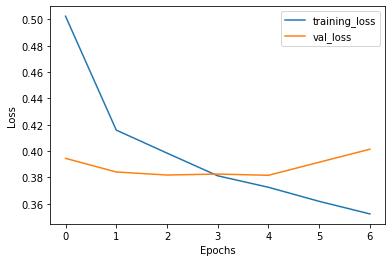

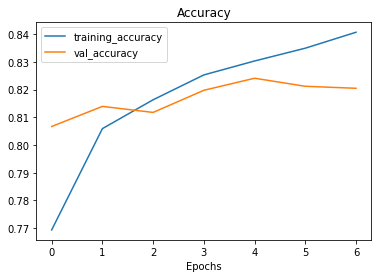

In [ ]:
plot_loss_curves(inceptionv3_hist)

In [ ]:
evaluate_models(inceptionv3_model, 'inceptionv3', test_data)

173/173 [==============================] - 9s 48ms/step - loss: 0.4010 - accuracy: 0.8198


### `ResNet101v2` Model

In [ ]:
resnet101v2 = applications.ResNet101V2(include_top=False)
base_model = resnet101v2
base_model.trainable=False
inputs = layers.Input(shape=(128,128,3), name='input_layer')
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dense(1)(x)
outputs = layers.Activation('sigmoid', dtype=tf.float32, name='sigmoid_float32')(x)
model = tf.keras.Model(inputs, outputs)

resnet101v2_hist, resnet101v2_model = create_model(train_data, 
                                                  test_data, 
                                                  model,
                                                  epochs = 10,
                                                  lr = 0.001)

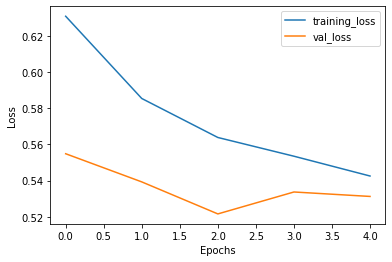

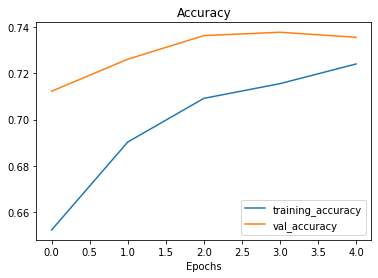

In [ ]:
plot_loss_curves(resnet101v2_hist)

In [ ]:
evaluate_models(resnet101v2_model, 'resnet101v2', test_data)

173/173 [==============================] - 10s 52ms/step - loss: 0.5421 - accuracy: 0.7296


### `VGG16` Model

In [ ]:
vgg16 = applications.VGG16(include_top=False)
base_model = vgg16
base_model.trainable=False
inputs = layers.Input(shape=(128,128,3), name='input_layer')
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1)(x)
outputs = layers.Activation('sigmoid', dtype=tf.float32, name='sigmoid_float32')(x)
model = tf.keras.Model(inputs, outputs)

vgg16_hist, vgg16_model = create_model(train_data, 
                                      test_data, 
                                      model,
                                      epochs = 10,
                                      lr = 0.001)

In [ ]:
plot_loss_curves(vgg16_hist)

In [ ]:
evaluate_models(vgg16_model, 'vgg16', test_data)

173/173 [==============================] - 8s 47ms/step - loss: 0.1499 - accuracy: 0.9506


### `VGG19` Model

In [ ]:
vgg19 = applications.VGG19(include_top=False)
base_model = vgg19
base_model.trainable=False
inputs = layers.Input(shape=(128,128,3), name='input_layer')
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1)(x)
outputs = layers.Activation('sigmoid', dtype=tf.float32, name='sigmoid_float32')(x)
model = tf.keras.Model(inputs, outputs)

vgg19_hist, vgg19_model = create_model(train_data, 
                                      test_data, 
                                      model,
                                      epochs = 10,
                                      lr = 0.001)

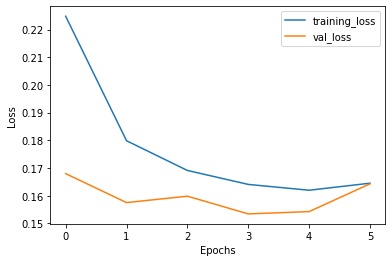

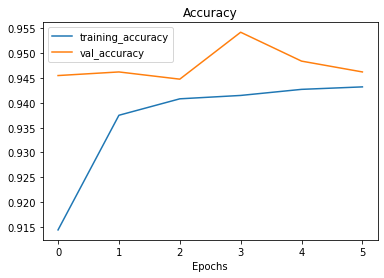

In [ ]:
plot_loss_curves(vgg19_hist)

In [ ]:
evaluate_models(vgg19_model, 'vgg19', test_data)

173/173 [==============================] - 9s 50ms/step - loss: 0.1551 - accuracy: 0.9463


## Feature Extraction Results

In [ ]:
feature_extraction_results = pd.DataFrame(accuracy_results.items(), columns = ['model','accuracy'])
feature_extraction_results.sort_values('accuracy', ascending=False)

,model,accuracy
2,vgg16,0.950644
3,vgg19,0.946289
0,inceptionv3,0.819815
1,resnet101v2,0.729632


## Fine Tuning The Top Two Models

In [ ]:
# Creating a function to fine tune the two models for 10 more epochs
# I will also experiment with different number of trainable layers

def fine_tuning(train_ds, test_ds, base_model, feature_extraction_model, num_layers, history, lr=0.0001):

  base_model.trainable=True
  for layer in base_model.layers[:-num_layers]:
    layer.trainable = False

  feature_extraction_model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                           metrics=['accuracy'])
  
  fine_tuned_model_hist = feature_extraction_model.fit(train_ds,
                                               epochs=history.epoch[-1]+10,
                                               validation_data=test_ds,
                                               validation_steps=int(0.25*len(test_ds)),
                                               initial_epoch = history.epoch[-1],
                                               callbacks=[model_checkpoint, early_stopping])
  
  return fine_tuned_model_hist, feature_extraction_model 

In [ ]:
# Refreshing the accuracy results database for fine tuning experiments
accuracy_results = dict() 

Experiment Outline For VGG16 Fine Tuning:

* Unfreeze the first 4 layers for training
* Unfreeze the first 8 layers for training
* Unfreeze every layer for training

In [ ]:
vgg16.layers

In [ ]:
# Reloading the vgg16 base model and feature extraction model

vgg16 = tf.keras.applications.VGG16(include_top=False)
vgg16_model = tf.keras.models.load_model('/content/drive/MyDrive/vgg16')

In [ ]:
evaluate_models(vgg16_model, 'vgg16 feature extraction', test_data)

173/173 [==============================] - 9s 47ms/step - loss: 0.1499 - accuracy: 0.9506


Unfreezing the first 4 layers

In [ ]:
vgg16_4layer_ft_hist, vgg16_4layer_ft_model = fine_tuning(train_data,
                                                          test_data,
                                                          vgg16,
                                                          vgg16_model,
                                                          4,
                                                          vgg16_hist,
                                                          lr = 0.0001)

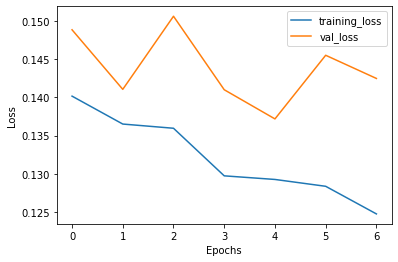

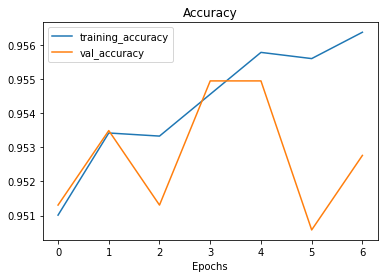

In [ ]:
plot_loss_curves(vgg16_4layer_ft_hist)

In [ ]:
evaluate_models(vgg16_4layer_ft_model, 'vgg16 4layer ft', test_data)

173/173 [==============================] - 8s 47ms/step - loss: 0.1395 - accuracy: 0.9534


Unfreezing the first 8 layers

In [ ]:
vgg16 = tf.keras.applications.VGG16(include_top=False)
vgg16_model = tf.keras.models.load_model('/content/drive/MyDrive/vgg16')

In [ ]:
vgg16_8layer_ft_hist, vgg16_8layer_ft_model = fine_tuning(train_data,
                                                          test_data,
                                                          vgg16,
                                                          vgg16_model,
                                                          8,
                                                          vgg16_hist,
                                                          lr = 0.0001)

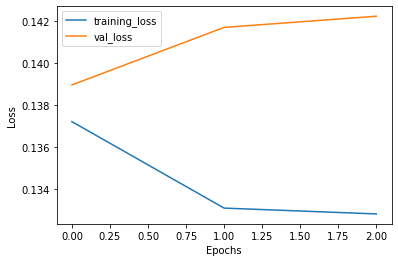

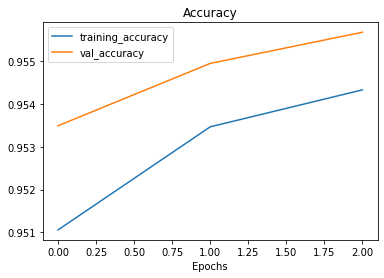

In [ ]:
plot_loss_curves(vgg16_8layer_ft_hist)

In [ ]:
evaluate_models(vgg16_8layer_ft_model, 'vgg16 8layer ft', test_data)

173/173 [==============================] - 8s 46ms/step - loss: 0.1397 - accuracy: 0.9541


Unfreezing every layer in the VGG16 base model

In [ ]:
vgg16 = tf.keras.applications.VGG16(include_top=False)
vgg16_model = tf.keras.models.load_model('/content/drive/MyDrive/vgg16')

In [ ]:
vgg16_full_ft_hist, vgg16_full_ft_model = fine_tuning(train_data,
                                                      test_data,
                                                      vgg16,
                                                      vgg16_model,
                                                      len(vgg16.layers),
                                                      vgg16_hist,
                                                      lr = 0.0001)

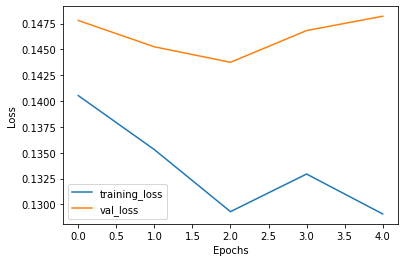

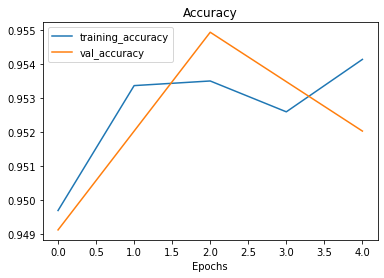

In [ ]:
plot_loss_curves(vgg16_full_ft_hist)

In [ ]:
evaluate_models(vgg16_full_ft_model, 'vgg16 full ft', test_data)

173/173 [==============================] - 8s 46ms/step - loss: 0.1412 - accuracy: 0.9535


Experiment Outline For VGG19 Fine Tuning:

* Unfreeze the first 5 layers for training
* Unfreeze the first 10 layers for training
* Unfreeze every layer for training

In [ ]:
vgg19.layers

In [ ]:
# Reloading the vgg19 base model and feature extraction model

vgg19 = tf.keras.applications.VGG19(include_top=False)
vgg19_model = tf.keras.models.load_model('/content/drive/MyDrive/vgg19')

In [ ]:
evaluate_models(vgg19_model, 'vgg19 feature extraction', test_data)

173/173 [==============================] - 9s 52ms/step - loss: 0.1584 - accuracy: 0.9427


Unfreezing the first 5 layers

In [ ]:
vgg19 = tf.keras.applications.VGG19(include_top=False)
vgg19_model = tf.keras.models.load_model('/content/drive/MyDrive/vgg19')

In [ ]:
vgg19_5layer_ft_hist, vgg19_5layer_ft_model = fine_tuning(train_data,
                                                          test_data,
                                                          vgg19,
                                                          vgg19_model,
                                                          5,
                                                          vgg19_hist,
                                                          lr = 0.0001)

In [ ]:
plot_loss_curves(vgg19_5layer_ft_hist)

In [ ]:
evaluate_models(vgg19_5layer_ft_model, 'vgg19 5layer ft', test_data)

173/173 [==============================] - 9s 52ms/step - loss: 0.1550 - accuracy: 0.9456


Unfreezing the first 10 layers

In [ ]:
vgg19 = tf.keras.applications.VGG19(include_top=False)
vgg19_model = tf.keras.models.load_model('/content/drive/MyDrive/vgg19')

In [ ]:
vgg19_10layer_ft_hist, vgg19_10layer_ft_model = fine_tuning(train_data,
                                                          test_data,
                                                          vgg19,
                                                          vgg19_model,
                                                          10,
                                                          vgg19_hist,
                                                          lr = 0.0001)

In [ ]:
plot_loss_curves(vgg19_10layer_ft_hist)

In [ ]:
evaluate_models(vgg19_10layer_ft_model, 'vgg19 10layer ft', test_data)

173/173 [==============================] - 9s 53ms/step - loss: 0.1546 - accuracy: 0.9465


Unfreezing every layer in the VGG19 base model

In [ ]:
vgg19 = tf.keras.applications.VGG19(include_top=False)
vgg19_model = tf.keras.models.load_model('/content/drive/MyDrive/vgg19')

In [ ]:
vgg19_full_ft_hist, vgg19_full_ft_model = fine_tuning(train_data,
                                                          test_data,
                                                          vgg19,
                                                          vgg19_model,
                                                          len(vgg19.layers),
                                                          vgg19_hist,
                                                          lr = 0.0001)

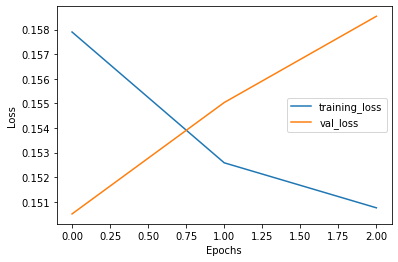

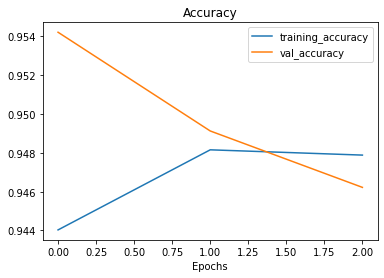

In [ ]:
plot_loss_curves(vgg19_full_ft_hist)

In [ ]:
evaluate_models(vgg19_full_ft_model, 'vgg19 full ft', test_data)

173/173 [==============================] - 10s 59ms/step - loss: 0.1537 - accuracy: 0.9452


## Evaluating The Best Model and Visualizing Its Predictions

In [ ]:
fine_tuning_results = pd.DataFrame(accuracy_results.items(), columns = ['model','accuracy'])
fine_tuning_results.sort_values('accuracy', ascending=False)

,model,accuracy
2,vgg16 8layer ft,0.954092
3,vgg16 full ft,0.953547
1,vgg16 4layer ft,0.953366
0,vgg16 feature extraction,0.950644
6,vgg19 10layer ft,0.946471
5,vgg19 5layer ft,0.945563
7,vgg19 full ft,0.945201
4,vgg19 feature extraction,0.942660


In [ ]:
vgg16_8layer_ft_model.save('drive/MyDrive/vgg16_malaria_detection_model')

INFO:tensorflow:Assets written to: drive/MyDrive/vgg16_malaria_detection_model/assets


VGG16 model comes on top with 95.41% accuracy. Unfortunately none of the models beat the 97.77%, however if you take a look at the [Improving Malaria Parasite Detection from Red Blood Cell using Deep Convolutional Neural Networks](https://arxiv.org/ftp/arxiv/papers/1907/1907.10418.pdf) paper, the researchers work with 137,940 samples after applying data augmentation on the initial 27,558 images. Considering they work with 5x more images, the 95.26% accuracy of the fine tuned vgg16 model is not so bad. Lets visualize some of the model's predictions

In [ ]:
vgg16_top_model = tf.keras.models.load_model('drive/MyDrive/vgg16_malaria_detection_model')

In [ ]:
def load_and_prep_image(filename, img_shape=128):
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  return img

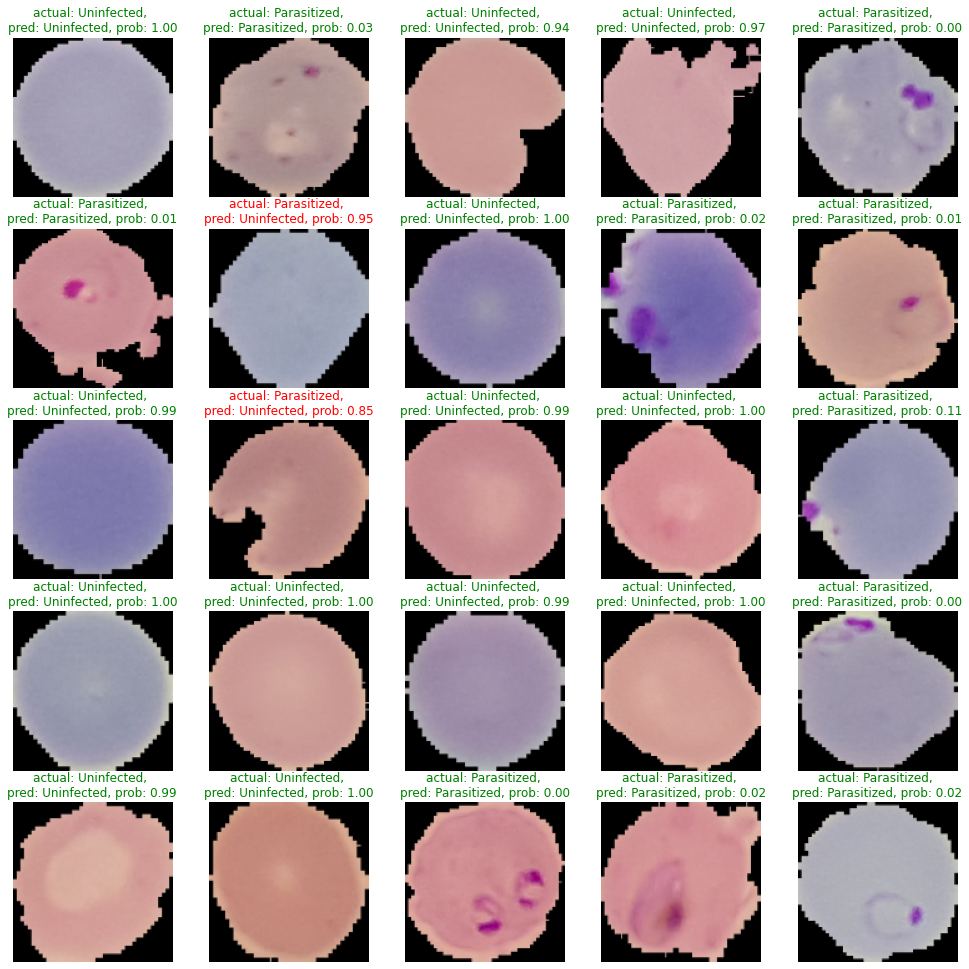

In [ ]:
plt.figure(figsize=(17, 17))
for i in range(25):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(data_dir.name + "/" + class_name))
  filepath = data_dir.name + "/" + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath) 
  pred_prob = vgg16_top_model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[int(np.round(pred_prob))] # find the predicted class 

  # Plot the image(s)
  plt.subplot(5, 5, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, \npred: {pred_class}, prob: {float(pred_prob):.2f}", c=title_color)
  plt.axis(False);

The model prediction for the second image in the second row is uninfected with 95% confidence. Even though the image is labelled as parasitized, the cell looks fairly intact (not distorted) and there are no visible color changes. In the other wrong prediction, the model predicts parasitized with 85% confidence for the uninfected blood cell. However, the shape of the cell is very distorted. It is understandable why the model predicted parasitized. That's why it is crucial to go visualize model's predictions and see where the model fails. Going through the dataset, removing the unclear images and correcting the mislabelled samples will improve the accuracy of the model.